In [28]:
# Importing data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <F2F42313-BF4F-3B95-A853-AE1DE94D4C87> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [2]:
# Loading three CSV files into pandas DataFrames
injury_data = pd.read_csv('InjuryRecord.csv')
play_data = pd.read_csv('PlayList.csv')
track_data = pd.read_csv('PlayerTrackData.csv')

In [19]:
# Merging Datasets: 
combined_data = pd.merge(play_data, track_data, on=['PlayKey'], how='inner')
# Adding a new column indicating weather or not an injury occured
combined_data['InjuryOccurred'] = combined_data['PlayKey'].isin(injury_data['PlayKey']).astype(int)

# Step 1: Split the data based on injury occurrence
injury_occurred = combined_data[combined_data['InjuryOccurred'] == 1]
no_injury_occurred = combined_data[combined_data['InjuryOccurred'] == 0]

# Step 2: Sample data
# Take 105 rows where injury occurred
injury_sample = injury_occurred.sample(n=105, random_state=42)
# Take 105 rows where no injury occurred
no_injury_sample = no_injury_occurred.sample(n=105, random_state=42)

# Step 3: Combine the samples
final_sample = pd.concat([injury_sample, no_injury_sample])

# Step 4: Shuffle the final dataset to randomize the order
random_sampled_data = final_sample.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
# Data Cleanup

# One-hot encoding for Weather data
weather_encoded = pd.get_dummies(random_sampled_data['Weather'], prefix='Weather')
# Combine the encoded columns with the original DataFrame
random_sampled_data = pd.concat([random_sampled_data, weather_encoded], axis=1)
# Drop the original 'Weather' column if no longer needed
random_sampled_data.drop(columns=['Weather'], inplace=True)

# Group definitions for weather categories
weather_groups = {
    'Sunny_Weather': [
        'Weather_Sunny', 'Weather_Sunny Skies', 'Weather_Sunny and clear',
        'Weather_Sunny and cold', 'Weather_Sunny and warm', 'Weather_Mostly sunny', 
        'Weather_Partly Sunny', 'Weather_Partly sunny', 
        'Weather_Sunny, Windy', 'Weather_Sunny, highs to upper 80s',  'Weather_Mostly Sunny', 'Weather_Mostly Sunny Skies'
    ],
    'Clear_Weather': [
        'Weather_Clear',
        'Weather_Clear Skies', 'Weather_Clear and Cool',
        'Weather_Clear and Sunny', 'Weather_Clear and cold',
        'Weather_Clear and sunny', 'Weather_Clear and warm',
        'Weather_Clear skies', 'Weather_Clear to Partly Cloudy', 'Weather_Partly clear'
    ],
    'Cloudy_Weather': [
        'Weather_Cloudy', 'Weather_Cloudy and Cool', 'Weather_Cloudy and cold',
        'Weather_Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Weather_Cloudy, 50% change of rain', 'Weather_Cloudy, Rain',
        'Weather_Cloudy, chance of rain', 'Weather_cloudy', 'Weather_Overcast', 
        'Weather_Cloudy, fog started developing in 2nd quarter',
        'Weather_Cloudy, light snow accumulating 1-3"', 'Weather_Coudy',
        'Weather_Mostly Cloudy', 'Weather_Mostly Coudy', 'Weather_Mostly cloudy'
    ],
    'Low_Rain_Weather': [
        'Weather_10% Chance of Rain', 'Weather_30% Chance of Rain', 'Weather_Light Rain'
    ],
    'Rainy_Weather': [
        'Weather_Rain', 'Weather_Rain Chance 40%', 'Weather_Rain likely, temps in low 40s.',
        'Weather_Rain shower', 'Weather_Rainy', 'Weather_Scattered Showers',
        'Weather_Showers'
    ],
    'Indoor_Weather': [
        'Weather_Indoor', 'Weather_Indoors', 'Weather_Controlled Climate',
        'Weather_N/A (Indoors)', 'Weather_N/A Indoor'
    ],
    'Partly_Cloudy_Weather': [
        'Weather_Partly Cloudy', 'Weather_Partly Clouidy', 'Weather_Partly cloudy',
        'Weather_Party Cloudy', 'Weather_Sun & clouds'
    ],
    'Snowy_Weather': [
        'Weather_Snow', 'Weather_Heavy lake effect snow'
    ],
    'Other_Weather': [
        'Weather_Fair', 'Weather_Hazy', 'Weather_Heat Index 95'
    ]
}

for group_name, columns in weather_groups.items():
    # Check if the columns exist in the DataFrame
    columns_present = [col for col in columns if col in random_sampled_data.columns]
    # Combine the columns
    random_sampled_data[group_name] = random_sampled_data[columns_present].max(axis=1)
    # Optionally drop the old columns
    random_sampled_data.drop(columns=columns_present, inplace=True)

field_type_encoded = pd.get_dummies(random_sampled_data['FieldType'], prefix='FieldType')
# Combine the encoded columns with the original DataFrame
random_sampled_data = pd.concat([random_sampled_data, field_type_encoded], axis=1)
# Drop the original 'FieldType' column if no longer needed
random_sampled_data.drop(columns=['FieldType'], inplace=True)

stadium_type_encoded = pd.get_dummies(random_sampled_data['StadiumType'], prefix='StadiumType')
# Combine the encoded columns with the original DataFrame
random_sampled_data = pd.concat([random_sampled_data, stadium_type_encoded], axis=1)
# Drop the original 'FieldType' column if no longer needed
random_sampled_data.drop(columns=['StadiumType'], inplace=True)

stadium_type_groups = {
    'Indoor_Stadium': [
        'StadiumType_Closed Dome', 'StadiumType_Dome', 'StadiumType_Dome, closed',
        'StadiumType_Domed', 'StadiumType_Indoor', 'StadiumType_Indoor, Open Roof',
        'StadiumType_Indoor, Roof Closed', 'StadiumType_Indoors'
    ],
    'Outdoor_Stadium': [
        'StadiumType_Bowl', 'StadiumType_Cloudy', 'StadiumType_Heinz Field',
        'StadiumType_Open', 'StadiumType_Oudoor', 'StadiumType_Ourdoor',
        'StadiumType_Outddors', 'StadiumType_Outdoor', 'StadiumType_Outdoors',
        'StadiumType_Outdor', 'StadiumType_Outside'
    ],
    'Retractable_Roof_Stadium': [
        'StadiumType_Domed, Open', 'StadiumType_Domed, open',
        'StadiumType_Outdoor Retr Roof-Open', 'StadiumType_Retr. Roof - Closed',
        'StadiumType_Retr. Roof - Open', 'StadiumType_Retr. Roof Closed', 'StadiumType_Domed, closed',
        'StadiumType_Retr. Roof-Closed', 'StadiumType_Retractable Roof', 'StadiumType_Retr. Roof-Open'
    ]
}
# Iterate through stadium type groups and combine columns
for group_name, columns in stadium_type_groups.items():
    # Check if the columns exist in the DataFrame
    columns_present = [col for col in columns if col in random_sampled_data.columns]
    # Combine the columns
    random_sampled_data[group_name] = random_sampled_data[columns_present].max(axis=1)
    # Optionally drop the old columns
    random_sampled_data.drop(columns=columns_present, inplace=True)

columns_of_interest  = [
    'Sunny_Weather', 'Clear_Weather', 'Cloudy_Weather', 'Low_Rain_Weather', 
    'Rainy_Weather', 'Indoor_Weather', 'Partly_Cloudy_Weather', 'Snowy_Weather', 
    'Other_Weather', 'FieldType_Natural', 'FieldType_Synthetic', 'Indoor_Stadium', 
    'Outdoor_Stadium', 'Retractable_Roof_Stadium'
]

# Apply the replacement for each column
for column in columns_of_interest:
    random_sampled_data[column] = random_sampled_data[column].replace({True: 1, False: 0})

X = random_sampled_data[['Sunny_Weather', 'Clear_Weather',
       'Cloudy_Weather', 'Low_Rain_Weather', 'Rainy_Weather', 'Indoor_Weather',
       'Partly_Cloudy_Weather', 'Snowy_Weather', 'Other_Weather',
       'FieldType_Natural', 'FieldType_Synthetic', 'Indoor_Stadium',
       'Outdoor_Stadium', 'Retractable_Roof_Stadium', 'Temperature']].fillna(0)
y = random_sampled_data['InjuryOccurred'].fillna(0)

/var/folders/1v/rphybfn151d42hnnhv4s72jm0000gn/T/ipykernel_72280/2704975574.py:115: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  random_sampled_data[column] = random_sampled_data[column].replace({True: 1, False: 0})


In [21]:
# Populating Training and Testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

For Random Forest Classifier               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.93      0.93      0.93        14

    accuracy                           0.90        21
   macro avg       0.89      0.89      0.89        21
weighted avg       0.90      0.90      0.90        21



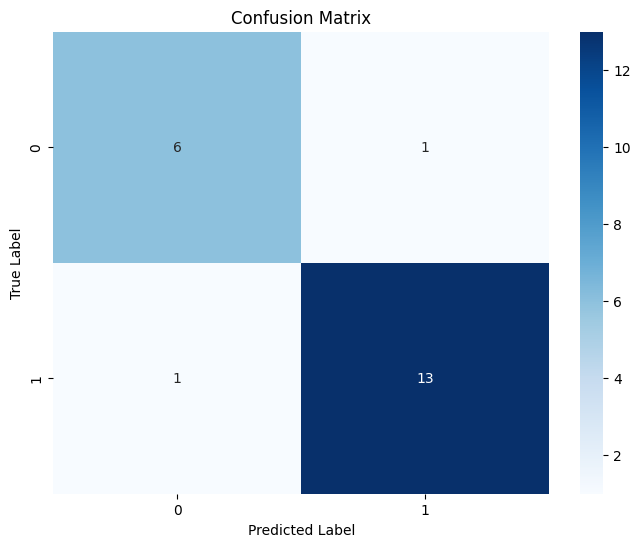

In [22]:
# Creating model for Random Forest

model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("For Random Forest Classifier",classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.50      0.71      0.59         7
           1       0.82      0.64      0.72        14

    accuracy                           0.67        21
   macro avg       0.66      0.68      0.65        21
weighted avg       0.71      0.67      0.68        21



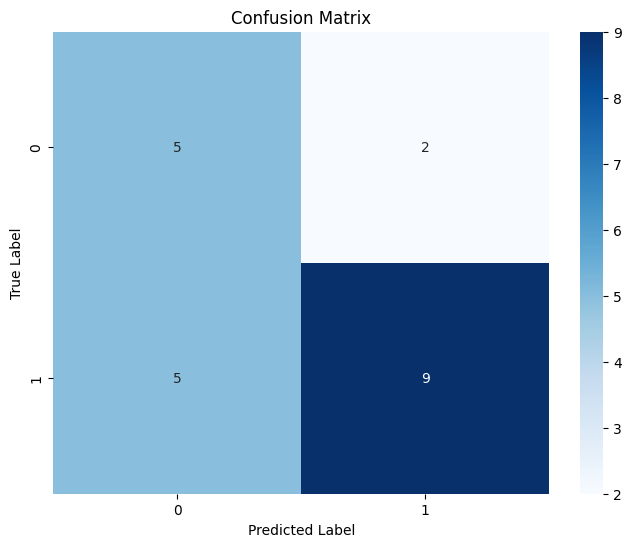

In [24]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         7
           1       0.00      0.00      0.00        14

    accuracy                           0.33        21
   macro avg       0.17      0.50      0.25        21
weighted avg       0.11      0.33      0.17        21



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

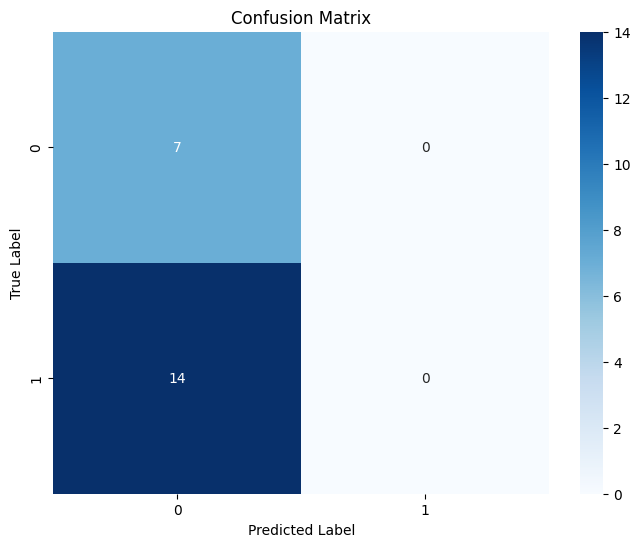

In [33]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf', random_state=42)  # Radial basis function kernel is commonly used for non-linear classification
svm_model.fit(X_train, y_train)
predictions = svm_model.predict(X_test)

print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [152]:
from tensorflow.keras.layers import Dense, Dropout, Input

def build_model(num_layers=5, neurons=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    # Use Input layer instead of input_dim in the Dense layer
    model.add(Input(shape=(X_train.shape[1],)))  # Define input shape here
    model.add(Dense(neurons, activation='relu'))  # First Dense layer after input
    
    # Add hidden layers
    for _ in range(num_layers):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
        
    # Output layer
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter tuning
num_layers = 9
neurons = 128
dropout_rate = 0.4
learning_rate = 0.001
batch_size = 64
# Build and train the model
model = build_model(num_layers=num_layers, neurons=neurons, dropout_rate=dropout_rate, learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=batch_size, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")


# Print the accuracy scores for each fold and the average 

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4714 - loss: 4.0964 - val_accuracy: 0.4706 - val_loss: 0.7466
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5096 - loss: 1.1425 - val_accuracy: 0.3824 - val_loss: 0.9669
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5549 - loss: 3.8115 - val_accuracy: 0.3824 - val_loss: 0.9208
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5229 - loss: 1.9218 - val_accuracy: 0.3824 - val_loss: 0.8006
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5341 - loss: 1.8335 - val_accuracy: 0.5882 - val_loss: 0.7474
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4943 - loss: 0.9800 - val_accuracy: 0.5588 - val_loss: 0.6964
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5169 - loss: 2.1080 - val_accuracy: 0.3824 - val_loss: 0.6945
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4730 - loss: 1.3547 - val_accuracy: 0.4118 - val_loss: 0.6946
Epoch 9

In [148]:
param_grid = {
    'num_layers': [3, 5, 7, 9],
    'neurons': [64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001],
    'batch_size': [32, 64, 72, 128]
}

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Initialize best metrics
best_accuracy = 0
best_loss = 2
best_params = {}
best_score = 0

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Iterate over all combinations of hyperparameters
for num_layers in param_grid['num_layers']:
    for neurons in param_grid['neurons']:
        for dropout_rate in param_grid['dropout_rate']:
            for learning_rate in param_grid['learning_rate']:
                for batch_size in param_grid['batch_size']:
                    # Build and train the model
                    model = build_model(num_layers=num_layers, neurons=neurons, dropout_rate=dropout_rate, learning_rate=learning_rate)
                    
                    # Train the model with the current hyperparameters
                    history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=batch_size, callbacks=[early_stopping], verbose=0)
                    
                    # Evaluate the model
                    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
                    if test_loss < 0.7 and test_accuracy> 0.5:
                        print(f"Evaluating model with params: num_layers={num_layers}, neurons={neurons}, "
                            f"dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}")
                        print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")
                    
                    score = test_accuracy - (test_loss * 0.5)  # You can adjust the weight factor
                    # Update the best parameters based on the score
                    if score > best_score:
                        best_score = score
                        best_accuracy = test_accuracy
                        best_loss = test_loss
                        best_params = {
                            'num_layers': num_layers,
                            'neurons': neurons,
                            'dropout_rate': dropout_rate,
                            'learning_rate': learning_rate,
                            'batch_size': batch_size
                        }

# Output the best combination of hyperparameters
print("\nBest Model Parameters:")
print(f"Test Accuracy: {best_accuracy:.2f}")
print(f"Test Loss: {best_loss:.2f}")
print(f"Best Hyperparameters: {best_params}")

Evaluating model with params: num_layers=9, neurons=128, dropout_rate=0.2, learning_rate=0.001, batch_size=32
Test Accuracy: 0.52, Test Loss: 0.69
Evaluating model with params: num_layers=9, neurons=128, dropout_rate=0.4, learning_rate=0.001, batch_size=64
Test Accuracy: 0.57, Test Loss: 0.68

Best Model Parameters:
Test Accuracy: 0.57
Test Loss: 0.68
Best Hyperparameters: {'num_layers': 9, 'neurons': 128, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 64}
